In [1]:
#imports
import torch
import os
from PIL import Image
import numpy as np
import random
from torchvision import transforms
import cv2
from matplotlib import pyplot as plt



### HELPER FUNCTIONS

In [12]:
# All helper functions for dataloader
def load_images(path):
    images = []
    valid_images = [".jpeg", ".jpg", '.png']
    for img in os.listdir(path):
        ext = os.path.splitext(img)[1]
        if ext.lower() not in valid_images:
            continue
        else:
            images.append(os.path.join(path, img))
    return images

def denormalize_tensor(normalize_tensor):
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
        std=[1/0.229, 1/0.224, 1/0.255]
    )
    return inv_normalize(normalize_tensor)

def plot_tensor(input_tensor, label):
    input_tensor = input_tensor.detach().cpu().numpy()
    input_tensor =  np.transpose(input_tensor, (1,2,0))
    plt.figure()
    plt.imshow(input_tensor, cmap='gray')
    plt.title(str(label))

    

### DATALOADERS

In [2]:
class DataloaderGenerator(object):
    def __init__(self, dataset_path, shape=(786,1024)):
        super().__init__()
        self.dataset_path = dataset_path

        self.cloth_dir_name = 'cloth'
        self.cloth_dir_path = os.path.join(self.dataset_path, self.cloth_dir_name)
        self.cloth_paths = load_images(self.cloth_dir_path)
    

        self.cloth_mask_dir_name = 'cloth-mask'
        self.cloth_mask_dir_path = os.path.join(self.dataset_path, self.cloth_mask_dir_name)
        self.cloth_mask_paths = load_images(self.cloth_mask_dir_path)

        self.person_with_cloth_dir_name = 'image'
        self.person_with_cloth_dir_path = os.path.join(self.dataset_path,
                                                        self.person_with_cloth_dir_name)
        self.person_with_cloth_paths = load_images(self.person_with_cloth_dir_path)

        self.normalize_img = transforms.Normalize(
            [0.485, 0.456, 0.406], #mean
            [0.229, 0.224, 0.225] #std
            )

        self.normalize_mask = transforms.Normalize(
            [0.5], [0.5]
            )

        self.transform_img = transforms.Compose([
            transforms.Resize(shape),
            transforms.CenterCrop(shape),
            transforms.ToTensor(),
            self.normalize_img
            ]
            
            )

        self.transform_mask = transforms.Compose([
            transforms.Resize(shape),
            transforms.CenterCrop(shape),
            transforms.ToTensor(),
            self.normalize_mask
            ])

    def __len__(self):
        return len(self.cloth_paths)

    def __getitem__(self, idx):
        cloth_path = self.cloth_paths[idx]
        person_with_cloth_path = self.person_with_cloth_paths[idx]
        person_with_cloth_mask_path = self.cloth_mask_paths[idx]

        target_cloth_idx = random.randint(0, len(self.cloth_paths)-1)
        target_cloth_path = self.cloth_paths[target_cloth_idx]

        cloth = Image.open(cloth_path)
        person_with_cloth = Image.open(person_with_cloth_path)
        person_with_cloth_mask = Image.open(person_with_cloth_mask_path)
        target_cloth = Image.open(target_cloth_path)
        
        cloth = self.transform_img(cloth)
        person_with_cloth = self.transform_img(person_with_cloth)
        target_cloth = self.transform_img(target_cloth)
        person_with_cloth_mask = self.transform_mask(person_with_cloth_mask)

        return cloth, person_with_cloth, person_with_cloth_mask, target_cloth

In [3]:
class DataloaderDiscriminator(object):
    def __init__(self, dataset_path, shape=(786,1024)):
        super().__init__()
        self.dataset_path = dataset_path
        self.cloth_dir_name = 'cloth'
        self.cloth_dir_path = os.path.join(self.dataset_path, self.cloth_dir_name)
        self.cloth_paths = load_images(self.cloth_dir_path)
    

        self.person_with_cloth_dir_name = 'image'
        self.person_with_cloth_dir_path = os.path.join(self.dataset_path,
                                                        self.person_with_cloth_dir_name)
        self.person_with_cloth_paths = load_images(self.person_with_cloth_dir_path)
    

        self.normalize = transforms.Normalize(
            [0.485, 0.456, 0.406],
            [0.229, 0.224, 0.225]
            )
        self.transform_img = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.Resize(shape),
            transforms.CenterCrop(shape),
            transforms.ToTensor(),
            self.normalize])

    def __len__(self):
        return len(self.cloth_paths)

    def __getitem__(self, idx):
        # only return real pair
        cloth_path = self.cloth_paths[idx]
        person_with_cloth_path = self.person_with_cloth_paths[idx]

        cloth = Image.open(cloth_path)
        person_with_cloth = Image.open(person_with_cloth_path)
    
        cloth = self.transform_img(cloth)
        person_with_cloth = self.transform_img(person_with_cloth)

        return cloth, person_with_cloth

### Testing DataLoaders

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


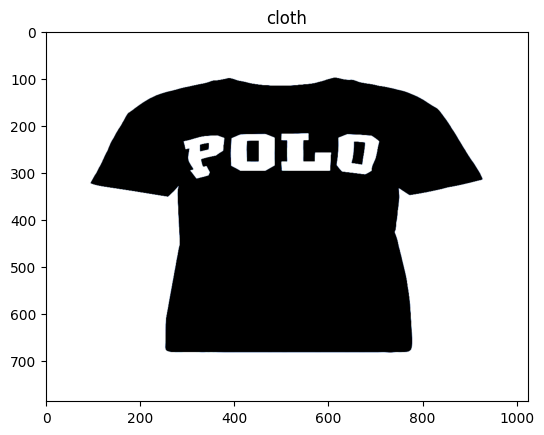

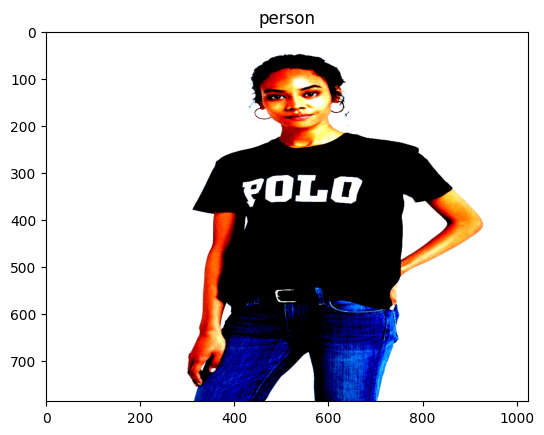

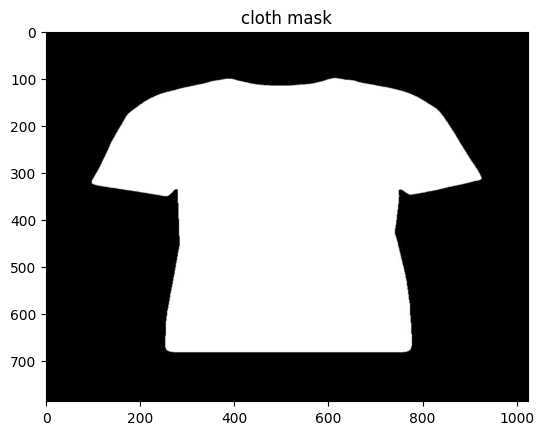

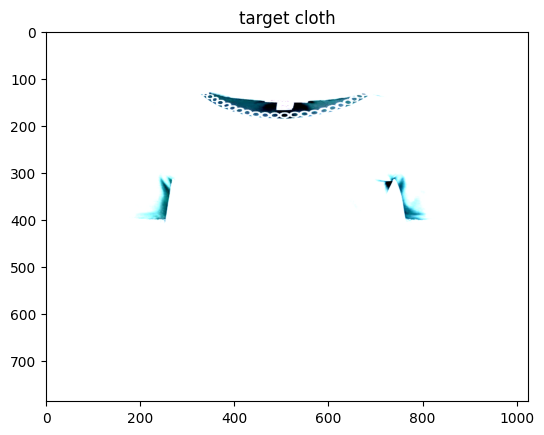

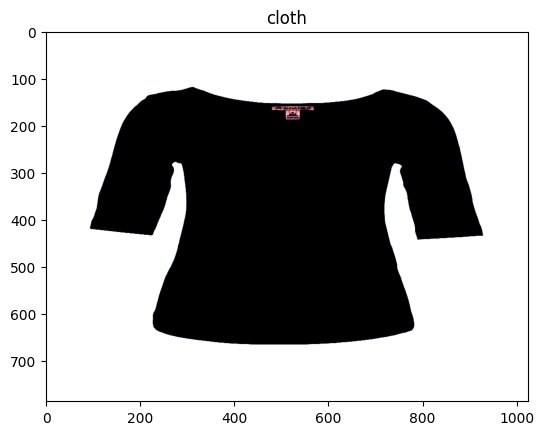

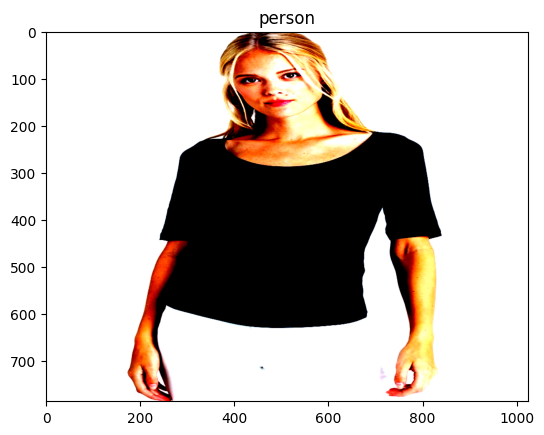

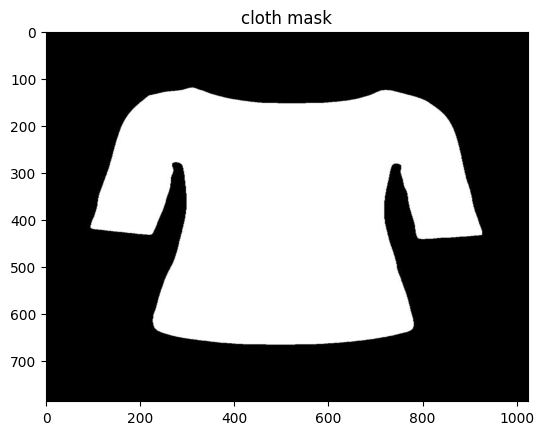

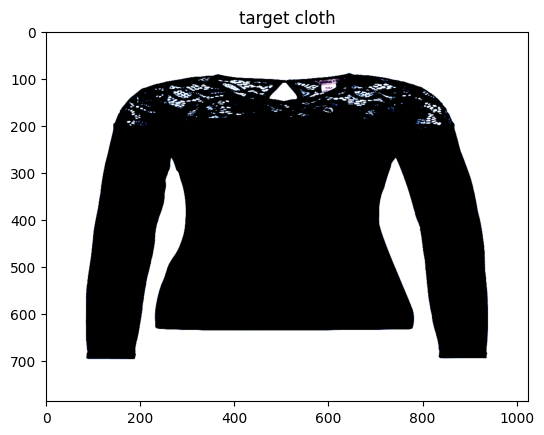

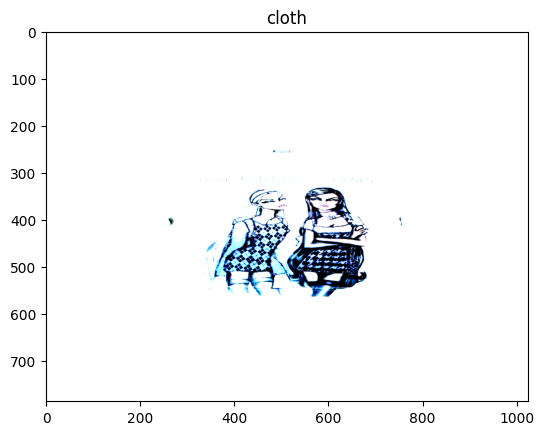

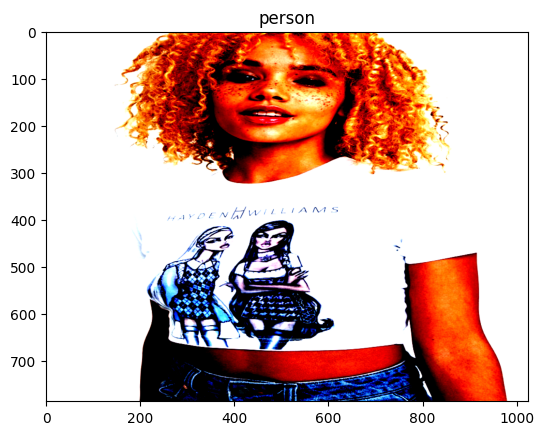

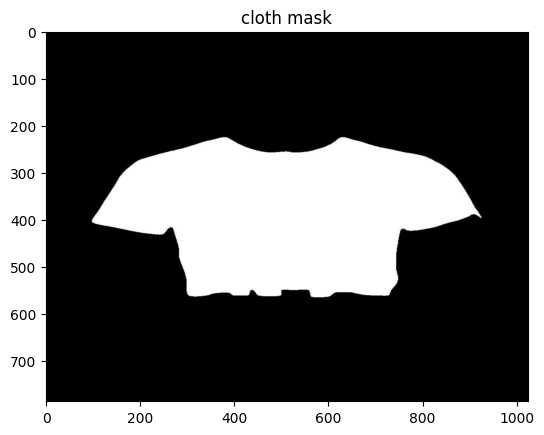

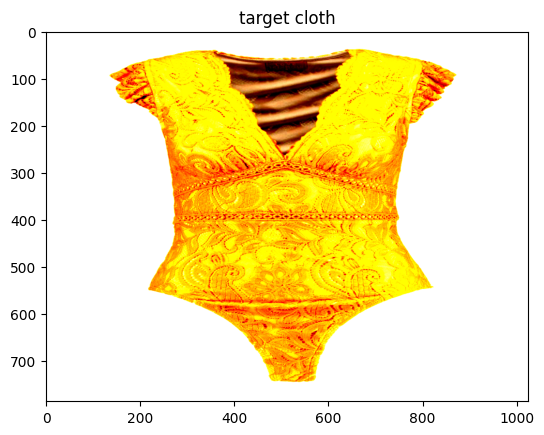

In [19]:

gen =  DataloaderGenerator('/Users/alijohnnaqvi/Desktop/Fall23/DeepLearning/WearVision/Data/zalando-hd-resized/train')
for i in range(3):
    c, p, pm, tc = gen.__getitem__(i)
    plot_tensor(c,'cloth')
    plot_tensor(p,'person')
    plot_tensor(pm,'cloth mask')
    plot_tensor(tc,'target cloth')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


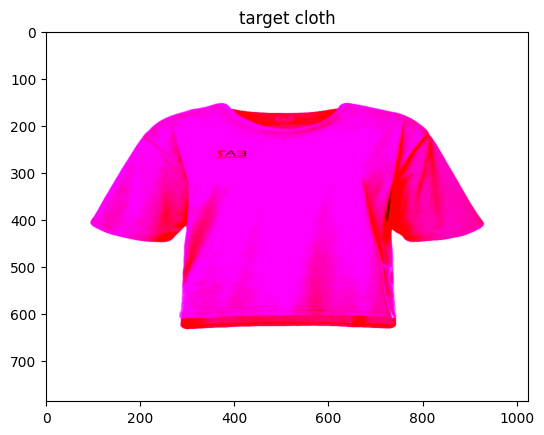

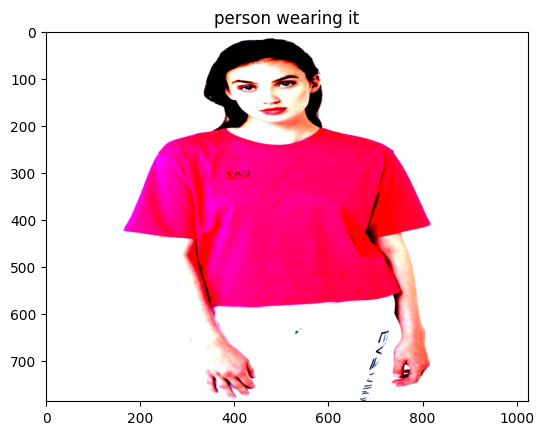

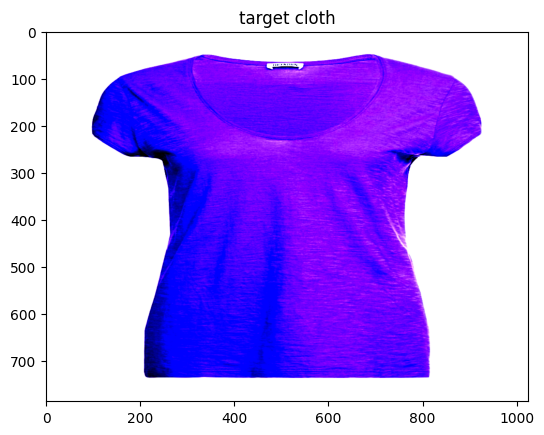

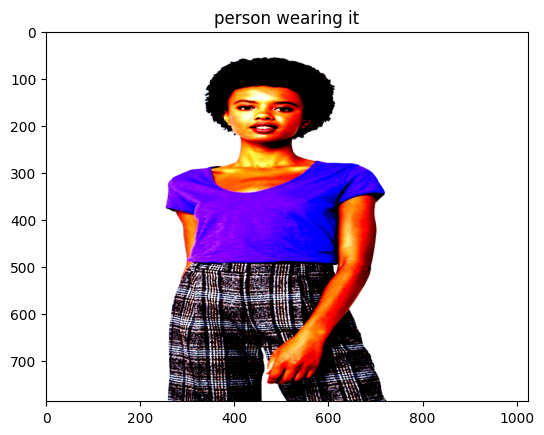

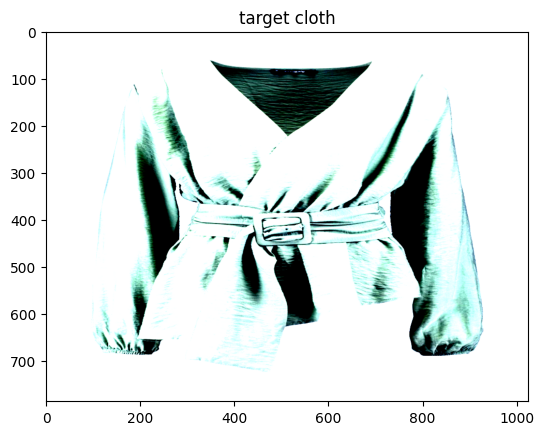

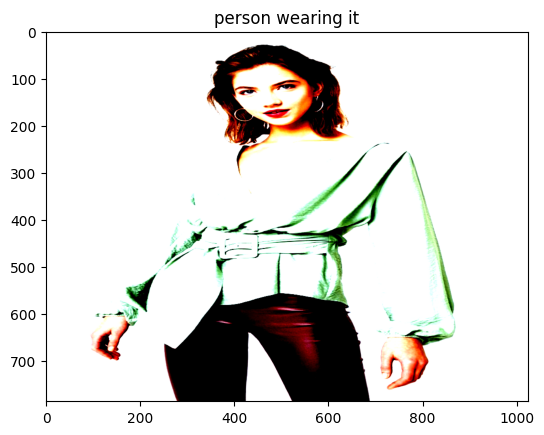

In [23]:
dis =  DataloaderDiscriminator('/Users/alijohnnaqvi/Desktop/Fall23/DeepLearning/WearVision/Data/zalando-hd-resized/train')
for i in range(3):
    j = random.randint(0,11640)
    c, p = dis.__getitem__(j)
    plot_tensor(c,'target cloth')
    plot_tensor(p,'person wearing it')
  